In [147]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_curve
from sklearn.preprocessing import MinMaxScaler
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import pickle

In [148]:
import warnings
warnings.filterwarnings("ignore")

In [149]:
trained_data = "train.csv"
test_data = "test.csv"

In [150]:
data_raw_trained = pd.read_csv(trained_data,header=0,sep=',',na_values='unknown')
data_raw_trained['Loan_Status'].replace('N', 0, inplace=True)
data_raw_trained['Loan_Status'].replace('Y', 1, inplace=True)

data_raw_test = pd.read_csv(test_data,header=0,sep=',',na_values='unknown')
loanID = data_raw_test.dropna().Loan_ID

## Data preparation

In [188]:
def preprocessing(data):
    data_raw_trained_clean = data.copy().drop('Loan_ID',axis=1)
    # Seperate between categorical and numerical data
    clean_data_obj = data_raw_trained_clean.select_dtypes(include=['object'])
    clean_data_num = data_raw_trained_clean.select_dtypes(exclude=['object']) 
    # One-hot categorical data
    clean_data_obj = pd.get_dummies(clean_data_obj,drop_first=True)
    scaler = MinMaxScaler()
    scaler.fit(clean_data_num)
    clean_data_num = pd.DataFrame(scaler.transform(clean_data_num),columns=clean_data_num.keys())
    data_raw_trained_clean = clean_data_num.join(clean_data_obj)
    return data_raw_trained_clean

In [189]:
train_x,test_x,train_y,test_y = train_test_split(features,label, test_size=0.33, random_state=42)

In [190]:
# Logistic Regression
lr_clf = LogisticRegression()
scores = cross_val_score(lr_clf,train_x,train_y,cv=3,scoring='roc_auc')

print(f"Logistic Regression model's average AUC: {scores.mean():.4f}")

Logistic Regression model's average AUC: 0.7424


In [191]:
# Decision Tree
tree_clf = DecisionTreeClassifier()
scores = cross_val_score(tree_clf,train_x,train_y,cv=10,scoring='roc_auc')

print(f"Tree Classifer model's average AUC: {scores.mean():.4f}")

Tree Classifer model's average AUC: 0.6744


In [192]:
# SVM
svm_clf = SVC()
scores = cross_val_score(svm_clf,train_x,train_y,cv=10,scoring='roc_auc')

print(f"SVM Classfier model's average AUC: {scores.mean():.4f}")

SVM Classfier model's average AUC: 0.7263


In [193]:
# XGBClassifier
xg_clf = XGBClassifier()
scores = cross_val_score(xg_clf,train_x,train_y,cv=10,scoring='roc_auc')

print(f"XG Classfier model's average AUC: {scores.mean():.4f}")

XG Classfier model's average AUC: 0.7311


## Selected Model Evaluation 

In [194]:
def eval_matrics(pred_class_y,pred_prob_y,label_y,model_name='Model'):
    # Matrics
    auc = roc_auc_score(label_y,pred_prob_y[:,1])
    print(f'{model_name} AUC is {auc:.4f}')
    acc = accuracy_score(label_y,pred_class_y)
    print(f'{model_name} Accuracy is {acc:.4f}')
    precision = precision_score(label_y,pred_class_y)
    print(f'{model_name} precision is {precision:.4f}')
    recall = recall_score(label_y,pred_class_y)
    print(f'{model_name} recall is {recall:.4f}')
    f1 = f1_score(label_y,pred_class_y)
    print(f'{model_name} f1-score is {f1:.4f}')
    # Confusion Matrix
    print(f'Confusion Matrix of {model_name}:')
    print(confusion_matrix(label_y,pred_class_y))
    return    

In [195]:
# LogisticRegression
lr_clf = LogisticRegression().fit(train_x,train_y)
pred_class_y = lr_clf.predict(test_x)
pred_prob_y = lr_clf.predict_proba(test_x)
# Evaluate
eval_matrics(pred_class_y,pred_prob_y,test_y,'Logistic Regression Model')


Logistic Regression Model AUC is 0.7956
Logistic Regression Model Accuracy is 0.8171
Logistic Regression Model precision is 0.7959
Logistic Regression Model recall is 0.9832
Logistic Regression Model f1-score is 0.8797
Confusion Matrix of Logistic Regression Model:
[[ 26  30]
 [  2 117]]


In [196]:
fpr_lr_base, tpr_lr_base ,_= roc_curve(test_y, pred_prob_y[:,1])

In [197]:
# XGBClassifier
xg_clf = XGBClassifier().fit(train_x,train_y)
pred_class_y = xg_clf.predict(test_x)
pred_prob_y = xg_clf.predict_proba(test_x)
# Evaluate
eval_matrics(pred_class_y,pred_prob_y,test_y,'XGBClassifier Model')

XGBClassifier Model AUC is 0.7756
XGBClassifier Model Accuracy is 0.8000
XGBClassifier Model precision is 0.7958
XGBClassifier Model recall is 0.9496
XGBClassifier Model f1-score is 0.8659
Confusion Matrix of XGBClassifier Model:
[[ 27  29]
 [  6 113]]


In [198]:
# Calculate fpr,and tpr for future ROC ploting
fpr_xg_base, tpr_xg_base ,_= roc_curve(test_y, pred_prob_y[:,1])

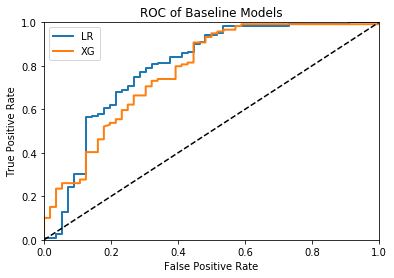

In [199]:

plt.plot(fpr_lr_base, tpr_lr_base ,linewidth=2, label='LR')
plt.plot(fpr_xg_base, tpr_xg_base ,linewidth=2, label='XG')
plt.plot([0,1],[0,1],'k--')
plt.axis([0,1,0,1])
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC of Baseline Models')
plt.show()

## Gridsearch

In [200]:
estimator = XGBClassifier(
    objective= 'binary:logistic',
    nthread=4,
    seed=42
)
parameters = {
    'max_depth': range (2, 10, 1),
    'n_estimators': range(60, 220, 40),
    'learning_rate': [0.1, 0.01, 0.05]
}
grid_search = GridSearchCV(
    estimator=estimator,
    param_grid=parameters,
    scoring = 'roc_auc',
    n_jobs = 10,
    cv = 10,
    verbose=True
)
grid_search.fit(train_x,train_y)


Fitting 10 folds for each of 96 candidates, totalling 960 fits


[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done  30 tasks      | elapsed:    2.2s
[Parallel(n_jobs=10)]: Done 286 tasks      | elapsed:    6.7s
[Parallel(n_jobs=10)]: Done 786 tasks      | elapsed:   15.2s
[Parallel(n_jobs=10)]: Done 960 out of 960 | elapsed:   18.6s finished


GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1),
       fit_params=None, iid='warn', n_jobs=10,
       param_grid={'max_depth': range(2, 10), 'n_estimators': range(60, 220, 40), 'learning_rate': [0.1, 0.01, 0.05]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=True)

In [201]:
grid_search.best_estimator_

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.01, max_delta_step=0,
       max_depth=2, min_child_weight=1, missing=None, n_estimators=140,
       n_jobs=1, nthread=4, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=42, silent=True,
       subsample=1)

In [202]:
xg_clf = XGBClassifier(silent=False, 
                      scale_pos_weight=1,
                      learning_rate=0.01,  
                      colsample_bytree = 1,
                      subsample = 1,
                      objective='binary:logistic', 
                      n_estimators=140, 
                      reg_alpha = 0.3,
                      max_depth=4, 
                      gamma=0)
pred_class_y = lr_clf.predict(test_x)
pred_prob_y = lr_clf.predict_proba(test_x)
eval_matrics(pred_class_y,pred_prob_y,test_y,'Tuned LR Model')

Tuned LR Model AUC is 0.7956
Tuned LR Model Accuracy is 0.8171
Tuned LR Model precision is 0.7959
Tuned LR Model recall is 0.9832
Tuned LR Model f1-score is 0.8797
Confusion Matrix of Tuned LR Model:
[[ 26  30]
 [  2 117]]


In [203]:
from sklearn.model_selection import train_test_split
data_raw_trained_clean = preprocessing(data_raw_trained)
data_raw_test_clean = preprocessing(data_raw_test)
features = data_raw_trained_clean.dropna().drop('Loan_Status',axis=1)
label = data_raw_trained_clean.dropna().Loan_Status

model = XGBClassifier()
model.fit(features, label)



XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [204]:
y_pred = model.predict(data_raw_test_clean)

In [208]:
df = pd.DataFrame(y_pred)
df.to_csv(r'status.csv')
# col_names =  ['Loan_Status']
# result_df  = pd.DataFrame(columns = col_names)
# result_df['Loan_Status'] = 

,0
0,1.0
1,1.0
2,1.0
3,0.0
4,0.0
5,1.0
6,1.0
7,0.0
8,1.0
9,1.0
